### measuring f1-score over different time points

Average cumulative f1 on the last day: 93.7
Average sliding f1 on the last day: 87.9


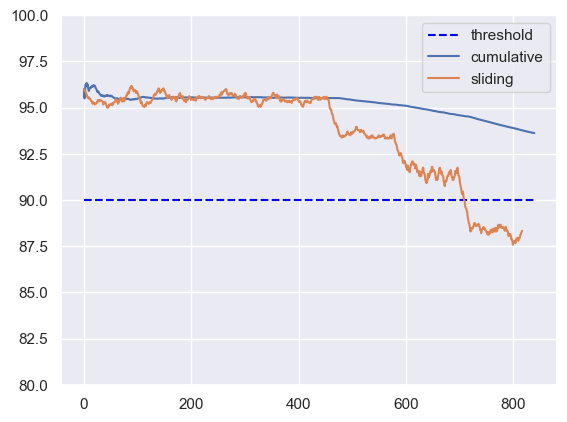

In [4]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
sns.set_theme()
# Generate data
hourly_f1 = list(np.random.randint(low=94, high=98, size=24*20)) + \
            list(np.random.randint(low=92, high=96, size=24*5)) + \
            list(np.random.randint(low=88, high=96, size=24*5)) + \
            list(np.random.randint(low=86, high=92, size=24*5))
# Cumulative f1
cumulative_f1 = [np.mean(hourly_f1[:n]) for n in range(1, len(hourly_f1)+1)]
print (f"Average cumulative f1 on the last day: {np.mean(cumulative_f1[-24:]):.1f}")
# Sliding f1
window_size = 24
sliding_f1 = np.convolve(hourly_f1, np.ones(window_size)/window_size, mode="valid")
print (f"Average sliding f1 on the last day: {np.mean(sliding_f1[-24:]):.1f}")
plt.ylim([80, 100])
plt.hlines(y=90, xmin=0, xmax=len(hourly_f1), colors="blue", linestyles="dashed", label="threshold")
plt.plot(cumulative_f1, label="cumulative")
plt.plot(sliding_f1, label="sliding")
plt.legend()

### Detecting Drift in model

In [6]:
import great_expectations as ge
import json
import pandas as pd
from urllib.request import urlopen
# Load labeled projects
projects = pd.read_csv("https://raw.githubusercontent.com/GokuMohandas/Made-With-ML/main/datasets/projects.csv")
tags = pd.read_csv("https://raw.githubusercontent.com/mknadi25/llm_app/main/datasets/tags.csv")
df = ge.dataset.PandasDataset(pd.merge(projects, tags, on="id"))
df["text"] = df.title + " " + df.description
df.drop(["title", "description"], axis=1, inplace=True)
df.head(5)

,id,created_on,tag,text
0,6,2020-02-20 06:43:18,computer-vision,Comparison between YOLO and RCNN on real world...
1,7,2020-02-20 06:47:21,computer-vision,"Show, Infer & Tell: Contextual Inference for C..."
2,9,2020-02-24 16:24:45,other,Awesome Graph Classification A collection of i...
3,15,2020-02-28 23:55:26,other,Awesome Monte Carlo Tree Search A curated list...
4,25,2020-03-07 23:04:31,other,"AttentionWalk A PyTorch Implementation of ""Wat..."


### rule_based expectations using ge python package

In [10]:
# Simulated production data
prod_df = ge.dataset.PandasDataset([{"text": "hello"}, {"text": 0}, {"text": "world"}])
# Expectation suite
df.expect_column_values_to_not_be_null(column="text")
df.expect_column_values_to_be_of_type(column="text", type_="str")
expectation_suite = df.get_expectation_suite()
# Validate reference data
df.validate(expectation_suite=expectation_suite, only_return_failures=True)["statistics"]

{'evaluated_expectations': 2,
 'successful_expectations': 2,
 'unsuccessful_expectations': 0,
 'success_percent': 100.0}

In [11]:
# Validate production data
prod_df.validate(expectation_suite=expectation_suite, only_return_failures=True)["statistics"]

{'evaluated_expectations': 2,
 'successful_expectations': 1,
 'unsuccessful_expectations': 1,
 'success_percent': 50.0}

### using KS test for checking the univariate drift in the input data, using the size of text feature(in this case the distribution for the number of tokens in two datasets, reference and test)

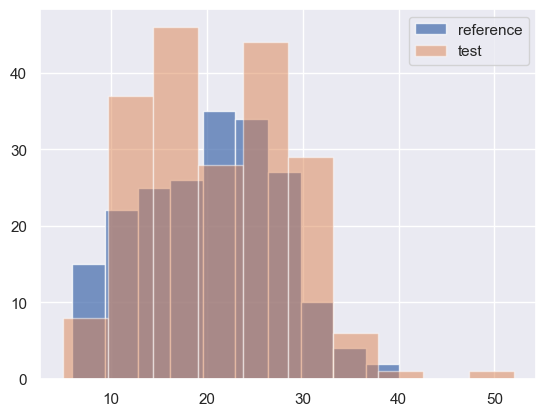

In [16]:
from alibi_detect.cd import KSDrift
# Reference
df["num_tokens"] = df.text.apply(lambda x: len(x.split(" ")))
ref = df["num_tokens"][0:200].to_numpy()
# Initialize drift detector
length_drift_detector = KSDrift(ref, p_val=0.01)
# No drift
no_drift = df["num_tokens"][200:400].to_numpy()
plt.hist(ref, alpha=0.75, label="reference")
plt.hist(no_drift, alpha=0.5, label="test")
plt.legend()
plt.show()

In [17]:
length_drift_detector.predict(no_drift, return_p_val=True, return_distance=True)

{'data': {'is_drift': 0,
  'distance': array([0.105], dtype=float32),
  'p_val': array([0.20524779], dtype=float32),
  'threshold': 0.01},
 'meta': {'name': 'KSDrift',
  'online': False,
  'data_type': None,
  'version': '0.12.0',
  'detector_type': 'drift'}}

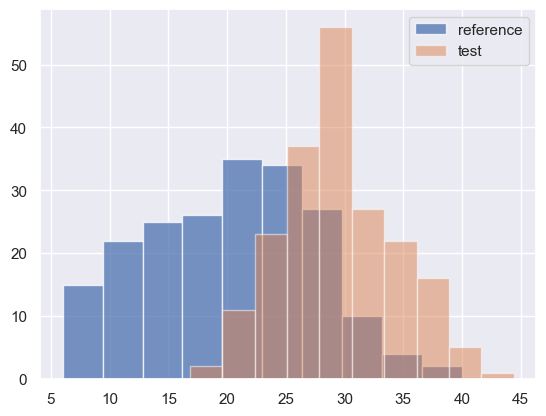

In [18]:
# Drift
drift = np.random.normal(30, 5, len(ref))
plt.hist(ref, alpha=0.75, label="reference")
plt.hist(drift, alpha=0.5, label="test")
plt.legend()
plt.show()

In [19]:
length_drift_detector.predict(drift, return_p_val=True, return_distance=True)

{'data': {'is_drift': 1,
  'distance': array([0.61], dtype=float32),
  'p_val': array([2.9666908e-36], dtype=float32),
  'threshold': 0.01},
 'meta': {'name': 'KSDrift',
  'online': False,
  'data_type': None,
  'version': '0.12.0',
  'detector_type': 'drift'}}